In [16]:
# !python3 -m pip install -r requirements.txt
%autosave 5

Autosaving every 5 seconds


In [ ]:
## Random Forest

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import connectorx as cx
import math
import time
import shap
import seaborn as sns
import os
import pandas as pd
from sqlalchemy import create_engine
import urllib.parse
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
import statistics
import xgboost as xgb
import plotly.express as px


In [18]:
database = 'isgpostgres'
user = 'postgres'
password = '123@NjMpTs'
host = '20.62.75.39'
port = '9030'
encoded_password = urllib.parse.quote(password)
connection_string = "postgresql+psycopg2://" + user + ":" + encoded_password + "@" + host + ":" + port + "/" + database
engine = create_engine(connection_string)


sql_command = """
select * from tm_new_data.current_connected_process_apr_27052024
"""

# Execute the query and fetch the data
data = pd.read_sql_query(sql_command, engine)




In [19]:
new_data = data.copy()

In [20]:
new_data.shape

(559258, 31)

In [21]:
new_data['arr_highway_id'] = list(map(lambda x : set(x) , new_data['arr_highway_id'])) 
new_data['arr_region'] = list(map(lambda x : set(x) , new_data['arr_region']))
new_data['arr_roadwaytype_id'] = list(map(lambda x : set(x) , new_data['arr_roadwaytype_id']))
new_data['arr_next_pcc'] = list(map(lambda x : set(x) , new_data['arr_next_pcc']))
new_data['arr_cur_lanes_cat'] = list(map(lambda x : set(x) , new_data['arr_cur_lanes_cat']))
new_data['arr_cur_spd_cat'] = list(map(lambda x : set(x) , new_data['arr_cur_spd_cat'])) 
new_data['arr_cur_cap_cat'] = list(map(lambda x : {int(float(e)) for e in x if e != None} ,new_data['arr_cur_cap_cat']))
new_data['arr_cur_final_place'] = list(map(lambda x : set(x) , new_data['arr_cur_final_place']))
new_data['arr_cur_areatype'] = list(map(lambda x : set(x) , new_data['arr_cur_areatype']))

In [22]:
columns_to_encode = ['arr_highway_id',
'arr_region',
'arr_roadwaytype_id',
'arr_next_pcc',
'arr_cur_lanes_cat',
'arr_cur_spd_cat',
'arr_cur_cap_cat',
'arr_cur_final_place',
'arr_cur_areatype']

# Function to encode a single column
def encode_column(column):
    # Convert the sets to sorted tuples
    new_data[f'{column}_tuple'] = new_data[column].apply(lambda x: tuple(sorted(x)))
    
    # Create a mapping from unique tuples to unique integers
    unique_tuples = new_data[f'{column}_tuple'].unique()
    tuple_to_int = {t: i for i, t in enumerate(unique_tuples)}
    
    # Map the tuples to integers
    new_data[f'{column}_encoded'] = new_data[f'{column}_tuple'].apply(lambda x: tuple_to_int[x])
    
    # Drop the intermediate tuple column
    new_data.drop(columns=[f'{column}_tuple'], inplace=True)

# Apply the encoding function to each specified column
for col in columns_to_encode:
    print(col)
    encode_column(col)

arr_highway_id
arr_region
arr_roadwaytype_id
arr_next_pcc
arr_cur_lanes_cat
arr_cur_spd_cat
arr_cur_cap_cat
arr_cur_final_place
arr_cur_areatype


In [23]:
new_data.isnull().sum()

conn_tag                            0
connected_isg_osm_id                0
connected_highway_id                0
connected_region                    0
connected_roadwaytype_id            0
connected_connected_count           0
connected_lanes                     0
connected_lanes_cat                 0
connected_maxspeed                  0
connected_spd_cat                   0
connected_final_place               0
connected_volume                    0
connected_areatype                  0
connected_capacity                360
connected_cap_cat                   0
arr_isg_osm_id                      0
arr_highway_id                      0
arr_region                          0
arr_roadwaytype_id                  0
arr_next_pcc                        0
arr_cur_lanes                       0
arr_cur_lanes_cat                   0
arr_cur_maxspeed                    0
arr_cur_spd_cat                     0
arr_cur_final_place                 0
arr_volume                          0
arr_cur_area

In [24]:
selective_features_lst = ['connected_highway_id', 'connected_region', 'connected_roadwaytype_id','connected_connected_count',
                          'connected_lanes_cat','connected_spd_cat','connected_cap_cat',
                          'connected_final_place','connected_areatype',
                           'arr_highway_id_encoded', 'arr_region_encoded', 'arr_roadwaytype_id_encoded', 'arr_next_pcc_encoded',
                          'arr_cur_lanes_cat_encoded', 'arr_cur_spd_cat_encoded', 'arr_cur_cap_cat_encoded',
                          'arr_cur_final_place_encoded', 'arr_cur_areatype_encoded',
                          'current_volume','connected_volume']

In [25]:
new_data_2 = new_data[selective_features_lst].copy()

In [26]:
new_data_2.isnull().sum()

connected_highway_id                0
connected_region                    0
connected_roadwaytype_id            0
connected_connected_count           0
connected_lanes_cat                 0
connected_spd_cat                   0
connected_cap_cat                   0
connected_final_place               0
connected_areatype                  0
arr_highway_id_encoded              0
arr_region_encoded                  0
arr_roadwaytype_id_encoded          0
arr_next_pcc_encoded                0
arr_cur_lanes_cat_encoded           0
arr_cur_spd_cat_encoded             0
arr_cur_cap_cat_encoded             0
arr_cur_final_place_encoded         0
arr_cur_areatype_encoded            0
current_volume                 455145
connected_volume                    0
dtype: int64

In [27]:
seen_df_1 = new_data_2[(new_data_2['connected_volume']>0 ) & (new_data_2['current_volume']>0 ) ]
un_seen_df_1 = new_data_2[(new_data_2['connected_volume'] < 0 ) & (new_data_2['current_volume']>0 )]

In [28]:
seen_df_1.shape,un_seen_df_1.shape

((74733, 20), (29380, 20))

In [29]:
seen_df_1.isnull().sum()

connected_highway_id           0
connected_region               0
connected_roadwaytype_id       0
connected_connected_count      0
connected_lanes_cat            0
connected_spd_cat              0
connected_cap_cat              0
connected_final_place          0
connected_areatype             0
arr_highway_id_encoded         0
arr_region_encoded             0
arr_roadwaytype_id_encoded     0
arr_next_pcc_encoded           0
arr_cur_lanes_cat_encoded      0
arr_cur_spd_cat_encoded        0
arr_cur_cap_cat_encoded        0
arr_cur_final_place_encoded    0
arr_cur_areatype_encoded       0
current_volume                 0
connected_volume               0
dtype: int64

In [30]:
uni_seen_df = seen_df_1.drop_duplicates()
uni_seen_df.shape

(27311, 20)

In [31]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit the LabelEncoder to the column and transform the values
uni_seen_df['connected_final_place'] = label_encoder.fit_transform(uni_seen_df['connected_final_place'])
# Fit the LabelEncoder to the column and transform the values
uni_seen_df['connected_areatype'] = label_encoder.fit_transform(uni_seen_df['connected_areatype'])

/tmp/ipykernel_14105/1431119123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_seen_df['connected_final_place'] = label_encoder.fit_transform(uni_seen_df['connected_final_place'])
/tmp/ipykernel_14105/1431119123.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_seen_df['connected_areatype'] = label_encoder.fit_transform(uni_seen_df['connected_areatype'])


In [32]:
input_feature_lst = ['connected_highway_id', 'connected_region', 'connected_roadwaytype_id','connected_connected_count',
                          'connected_lanes_cat','connected_spd_cat','connected_cap_cat',
                          'connected_final_place','connected_areatype',
                           'arr_highway_id_encoded', 'arr_region_encoded', 'arr_roadwaytype_id_encoded', 'arr_next_pcc_encoded',
                          'arr_cur_lanes_cat_encoded', 'arr_cur_spd_cat_encoded', 'arr_cur_cap_cat_encoded',
                          'arr_cur_final_place_encoded', 'arr_cur_areatype_encoded',
                          'current_volume']
target_feature_lst= ['connected_volume']

In [33]:
X,y = uni_seen_df[input_feature_lst],uni_seen_df[target_feature_lst]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((21848, 19), (5463, 19), (21848, 1), (5463, 1))

In [34]:
# def geh_check(current_vol,next_vol):
#     return round(math.sqrt(2*((current_vol-next_vol)*(current_vol-next_vol))/(current_vol+next_vol)),2)

def geh_check(y_true, y_pred):
    current_vol = y_true
    next_vol = y_pred
    metric_value = float(np.sqrt(2 * np.sum((current_vol - next_vol) ** 2) / np.sum(current_vol + next_vol)))
    return metric_value

In [35]:
def mean_geh(y_test, y_pred):
    geh_lst = []
    for i,j in zip(y_test, y_pred):
        geh_lst.append(geh_check(i,j))
    return statistics.mean(geh_lst)

In [36]:
def log_model_summary(xg_reg,X_train,X_test,y_train,y_test,y_pred):
    
    # Log Parameter
    xgb_params = xg_reg.get_params()
    mlflow.log_params(xgb_params)
    
    Test_Data_Df = X_test.copy()
    Test_Data_Df['connected_volume'] = y_test['connected_volume']
    Test_Data_Df['predicted_connected_volume']=y_pred
    Test_Data_Df['predicted_connected_volume']=Test_Data_Df['predicted_connected_volume'].round().astype(int)
    Test_Data_Df['diff']=Test_Data_Df['connected_volume']-Test_Data_Df['predicted_connected_volume']
    Test_Data_Df['geh'] = Test_Data_Df.apply(lambda row: geh_check(row['connected_volume'], row['predicted_connected_volume']), axis=1)
    Test_Data_Df['geh'] = Test_Data_Df['geh'].round(2)
    
    # Log Metrics
    mse = round(mean_squared_error(y_test, y_pred),3)
    rmse = round(np.sqrt(mse),3)
    r2 = round(r2_score(y_test, y_pred),3)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2score =  round((1 - (1 - r2) * (n - 1) / (n - p - 1)),3)
    mae = round(mean_absolute_error(y_test, y_pred),3)
    
    m_geh = round(mean_geh(y_test.values, y_pred),3)
    geh_grt_5 = Test_Data_Df[Test_Data_Df['geh']>5].shape[0]
    geh_error_per = round(((geh_grt_5/n)*100),3)
    
    metrics = {'mse':mse,'rmse':rmse,'r2score':r2,'mae':mae,'adjusted_r2score' : adjusted_r2score,
               'mean_geh':m_geh,'test_data_size':n,'geh_grt_5':geh_grt_5,'geh_error_per':geh_error_per}
    
    mlflow.log_metrics(metrics)
    
    
    # log tags
    tags = {'Model_Name' : 'XGBoost',
            'Train Size' : X_train.shape[0],
            'Test Size' : X_test.shape[0],
            'No. Of Input Feature' : len(input_feature_lst),
            'No. Of Target Feature ': len(target_feature_lst),
            'input_feature_lst':input_feature_lst,
            'target_feature_lst': target_feature_lst}
    
    mlflow.set_tags(tags)

    return  Test_Data_Df

In [37]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'isgadmin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'infosense12@'
tracking_server_uri = "https://ptt2-mlflow.isgsuite.com/"
mlflow.set_tracking_uri(tracking_server_uri)
tracking_uri = mlflow.get_tracking_uri()
print("Tracking URI:", tracking_uri)

Tracking URI: https://ptt2-mlflow.isgsuite.com/


In [38]:
# experiment_name = "TM_New_Approach"
# experiment = mlflow.set_experiment(experiment_name)
# experiment_id = experiment.experiment_id
run_name = 'RF_FC_1_2_3'
description = 'Predicting for function class 1,2,3 using multi input as column'
# Get Experiment Details
# print(f"Experiment_id: {experiment.experiment_id}")
print(f"Run Name: {run_name}")
print(f"Description: {description}")
# print(f"Artifact Location: {experiment.artifact_location}")

Run Name: RF_FC_1_2_3
Description: Predicting for function class 1,2,3 using multi input as column


2024/05/28 10:56:17 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



RandomForestRegressor(bootstrap=False, criterion='poisson', max_depth=8,
                      max_features=0.6, max_leaf_nodes=2000,
                      min_samples_leaf=15, n_estimators=500, random_state=1234)


/usr/local/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

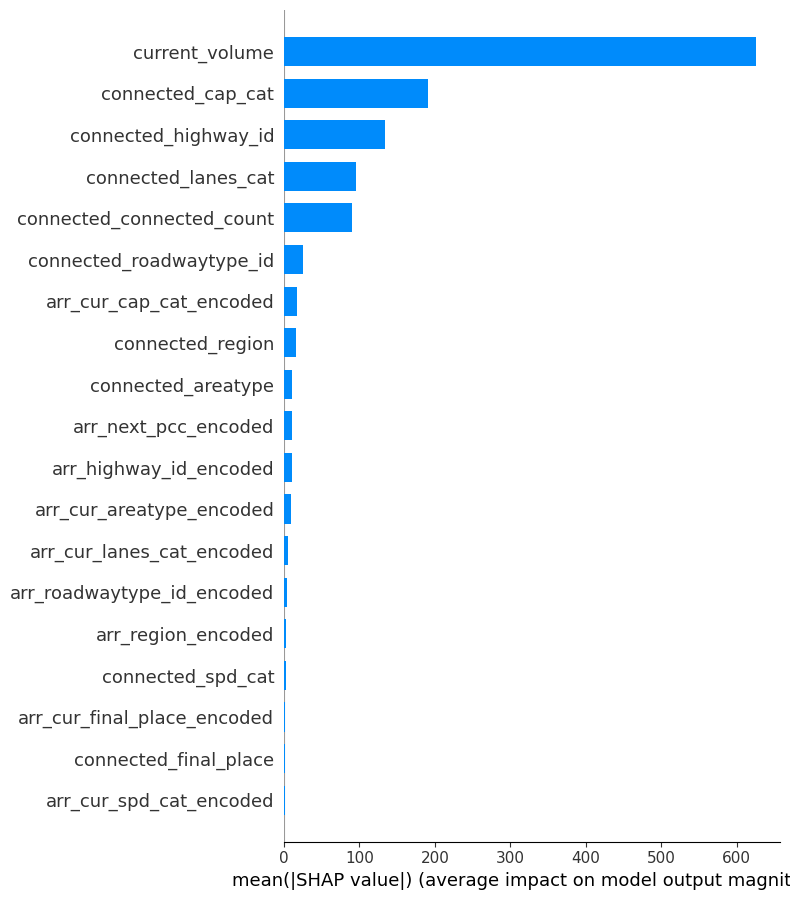

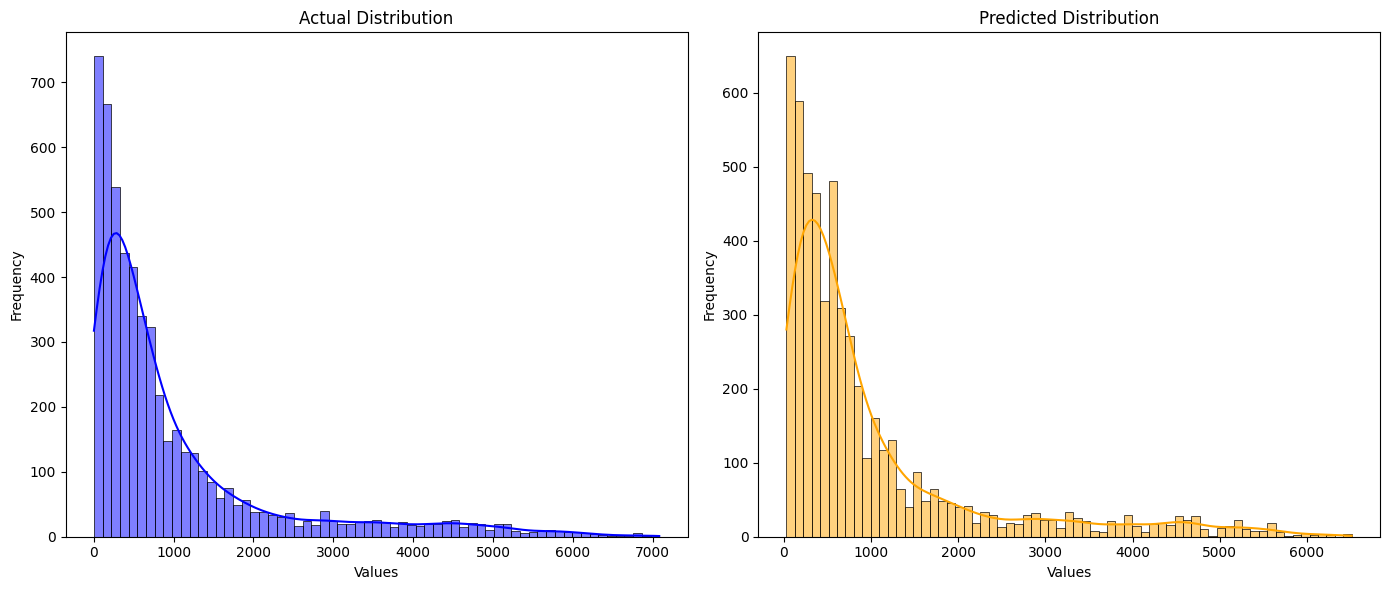

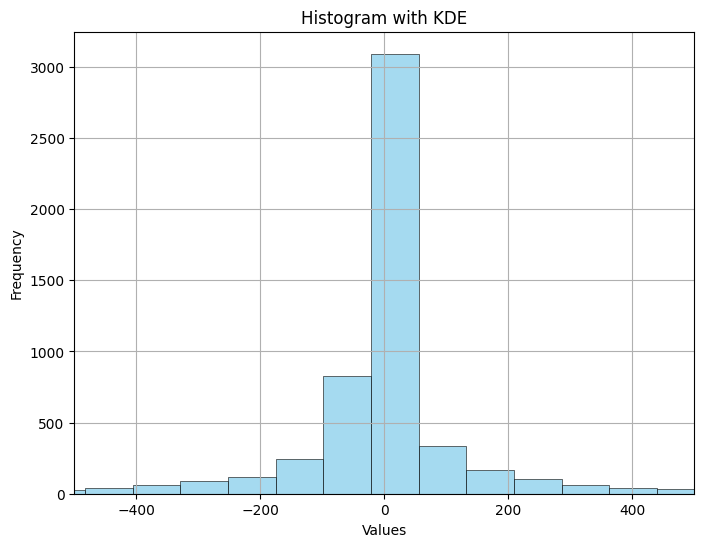

In [39]:
with mlflow.start_run(experiment_id="59",run_name = run_name,description=description) as run:

    # Define the XGBoost regressor with the specified parameters
    params = {
    'n_estimators' : 500,
    'max_depth' : 8,
    'max_leaf_nodes' : 2000,
    'min_samples_split' : 2,
    'min_samples_leaf' : 15,
    'bootstrap' : False,
    'random_state' : 1234,
    'criterion' : 'poisson',
    'max_features' : 0.6
    }
    
    # Train the model
    xg_reg = RandomForestRegressor(**params)
    print(xg_reg)
    xg_reg.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = xg_reg.predict(X_test)
    y_test['connected_volume'] = round(y_test['connected_volume'],0).astype(int)
    y_pred = np.rint(y_pred).astype(int)
    
    # Log Model Summary
    Test_Data_Df = log_model_summary(xg_reg,X_train,X_test,y_train,y_test,y_pred)
    
    # Store Indexes
    # X_train_index = seen_df_1[seen_df_1.index.isin(X_train.index)].row_num.tolist()
    # X_test_index = seen_df_1[seen_df_1.index.isin(X_test.index)].row_num.tolist()
    # data_json = {'X_train_index': X_train_index,'X_test_index': X_test_index}
    
    # mlflow.log_dict(data_json, "Data_Index.json")
   
    
    # Log Feature Importance

    explainer = shap.TreeExplainer(xg_reg)
    shap_values = explainer.shap_values(X_train[:500])
    fig = shap.summary_plot(shap_values, X_train[:500], plot_type="bar",show=False)
    # Save the Image
    image_path = "Feature_Importance.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path, "images")
    
#     Actual Vs Prediction Plot
    fig = px.scatter(Test_Data_Df, x='connected_volume', y='predicted_connected_volume')
    fig.add_trace(px.line(Test_Data_Df, x='connected_volume', y='connected_volume').data[0])
    fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values')
    html_str = fig.to_html(full_html=False)
    with open("Actual_Vs_Prediction_Plot.html", "w") as f:
        f.write(html_str)
    mlflow.log_artifact("Actual_Vs_Prediction_Plot.html", "html")
        
#     Actual And Prediction Distribution
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(Test_Data_Df['connected_volume'], color='blue', kde=True, ax=axs[0])
    axs[0].set_title('Actual Distribution')
    axs[0].set_xlabel('Values')
    axs[0].set_ylabel('Frequency')
    sns.histplot(Test_Data_Df['predicted_connected_volume'], color='orange', kde=True, ax=axs[1])
    axs[1].set_title('Predicted Distribution')
    axs[1].set_xlabel('Values')
    axs[1].set_ylabel('Frequency')
    plt.tight_layout()

    image_path = "Actual_And_Prediction_Distribution.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path, "images")
    
    
#     Residuals Plot
    plt.figure(figsize=(8, 6))
    sns.histplot(Test_Data_Df['diff'], bins=100, kde=False, color='skyblue')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram with KDE')
    plt.xlim(-500, 500)
    plt.grid(True)
    
    image_path = "Residuals_Plot.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path, "images")
    
#     Log Model
    signature = infer_signature(X_test, xg_reg.predict(X_test))
    mlflow.sklearn.log_model(xg_reg, "model", signature=signature)
    
    mlflow.end_run()  

In [40]:
Test_Data_Df[Test_Data_Df['geh']>5].shape

(1117, 23)

### Prepare Data For unseen data

In [41]:
un_seen_df_1.shape

(29380, 20)

In [46]:
# Fit the LabelEncoder to the column and transform the values
un_seen_df_1['connected_final_place'] = label_encoder.fit_transform(un_seen_df_1['connected_final_place'])
# Fit the LabelEncoder to the column and transform the values
un_seen_df_1['connected_areatype'] = label_encoder.fit_transform(un_seen_df_1['connected_areatype'])

/tmp/ipykernel_14105/1896438176.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_14105/1896438176.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
un_seen_df_1.columns

Index(['connected_highway_id', 'connected_region', 'connected_roadwaytype_id',
       'connected_connected_count', 'connected_lanes_cat', 'connected_spd_cat',
       'connected_cap_cat', 'connected_final_place', 'connected_areatype',
       'arr_highway_id_encoded', 'arr_region_encoded',
       'arr_roadwaytype_id_encoded', 'arr_next_pcc_encoded',
       'arr_cur_lanes_cat_encoded', 'arr_cur_spd_cat_encoded',
       'arr_cur_cap_cat_encoded', 'arr_cur_final_place_encoded',
       'arr_cur_areatype_encoded', 'current_volume', 'connected_volume'],
      dtype='object')

In [61]:
# filtered_df = data[data['arr_next_pcc'].apply(lambda x: any(i > 1 for i in x))]

extract_df = filtered_df[((filtered_df['connected_connected_count'] > 1)|\
                         (filtered_df['extract'] > 1))&\
                            (filtered_df['connected_volume'] < 0) & \
                            (filtered_df['current_volume'] > 0)]


index_lst =  extract_df.index

In [62]:
unseen_df = un_seen_df_1[un_seen_df_1.index.isin(index_lst)]
unseen_df.shape

(28599, 20)

In [55]:
# unseen_df.to_csv('unseen_df.csv')

In [63]:
xg_reg

RandomForestRegressor(bootstrap=False, criterion='poisson', max_depth=8,
                      max_features=0.6, max_leaf_nodes=2000,
                      min_samples_leaf=15, n_estimators=500, random_state=1234)

In [64]:
unseen_pred = xg_reg.predict(unseen_df[input_feature_lst])

In [65]:
unseen_df['predicted_connected_volume'] = unseen_pred
unseen_df['predicted_connected_volume'] = unseen_df['predicted_connected_volume'].round().astype(int)

/tmp/ipykernel_14105/2600663216.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_14105/2600663216.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
unseen_df.shape

(28599, 21)

In [67]:
unseen_df.columns

Index(['connected_highway_id', 'connected_region', 'connected_roadwaytype_id',
       'connected_connected_count', 'connected_lanes_cat', 'connected_spd_cat',
       'connected_cap_cat', 'connected_final_place', 'connected_areatype',
       'arr_highway_id_encoded', 'arr_region_encoded',
       'arr_roadwaytype_id_encoded', 'arr_next_pcc_encoded',
       'arr_cur_lanes_cat_encoded', 'arr_cur_spd_cat_encoded',
       'arr_cur_cap_cat_encoded', 'arr_cur_final_place_encoded',
       'arr_cur_areatype_encoded', 'current_volume', 'connected_volume',
       'predicted_connected_volume'],
      dtype='object')

In [68]:
new_unseen_df_1 = data[data.index.isin(unseen_df.index)]

In [69]:
new_unseen_df_1.shape

(28599, 31)

In [70]:
new_unseen_df_1.columns

Index(['conn_tag', 'connected_isg_osm_id', 'connected_highway_id',
       'connected_region', 'connected_roadwaytype_id',
       'connected_connected_count', 'connected_lanes', 'connected_lanes_cat',
       'connected_maxspeed', 'connected_spd_cat', 'connected_final_place',
       'connected_volume', 'connected_areatype', 'connected_capacity',
       'connected_cap_cat', 'arr_isg_osm_id', 'arr_highway_id', 'arr_region',
       'arr_roadwaytype_id', 'arr_next_pcc', 'arr_cur_lanes',
       'arr_cur_lanes_cat', 'arr_cur_maxspeed', 'arr_cur_spd_cat',
       'arr_cur_final_place', 'arr_volume', 'arr_cur_areatype',
       'arr_cur_capacity', 'arr_cur_cap_cat', 'cur_vol_filter_arr',
       'current_volume'],
      dtype='object')

In [71]:
new_unseen_df_1.head()

,conn_tag,connected_isg_osm_id,connected_highway_id,connected_region,connected_roadwaytype_id,connected_connected_count,connected_lanes,connected_lanes_cat,connected_maxspeed,connected_spd_cat,...,arr_cur_lanes_cat,arr_cur_maxspeed,arr_cur_spd_cat,arr_cur_final_place,arr_volume,arr_cur_areatype,arr_cur_capacity,arr_cur_cap_cat,cur_vol_filter_arr,current_volume
33,next,5029221001,5,11,10,3,3,2,25,1,...,[2],[25],[1],[city],[1216],[Urban],[3800],[2],[1216],1216.0
39,next,5563942001,2,1,18,2,1,1,25,1,...,[2],[55],[3],[city],[4577],[Urban],[6148],[3],[4577],4577.0
42,next,5563954002,2,1,16,1,1,1,25,1,...,"[1, 1]","[20, 25]","[1, 1]","[city, city]","[-1, 847]","[Urban, Urban]","[1800, 1800]","[1, 1]",[847],847.0
43,next,5563966001,6,1,16,2,1,1,40,2,...,"[2, 2]","[40, 40]","[2, 2]","[town, town]","[-1, 1060]","[Urban, Urban]","[1900, 1900]","[1, 1]",[1060],1060.0
50,next,5564067001,6,1,16,2,1,1,55,3,...,[1],[55],[3],[town],[480],[Urban],[950],[0],[480],480.0


In [72]:
unseen_df.head()

,connected_highway_id,connected_region,connected_roadwaytype_id,connected_connected_count,connected_lanes_cat,connected_spd_cat,connected_cap_cat,connected_final_place,connected_areatype,arr_highway_id_encoded,...,arr_roadwaytype_id_encoded,arr_next_pcc_encoded,arr_cur_lanes_cat_encoded,arr_cur_spd_cat_encoded,arr_cur_cap_cat_encoded,arr_cur_final_place_encoded,arr_cur_areatype_encoded,current_volume,connected_volume,predicted_connected_volume
33,5,11,10,3,2,1,2,0,1,3,...,0,2,0,4,1,2,0,1216.0,-1,1107
39,2,1,18,2,1,1,1,0,1,0,...,3,0,0,0,0,2,0,4577.0,-1,718
42,2,1,16,1,1,1,1,0,1,2,...,2,1,2,4,4,2,0,847.0,-1,865
43,6,1,16,2,1,2,0,4,1,3,...,6,1,0,5,4,0,0,1060.0,-1,429
50,6,1,16,2,1,3,0,4,1,3,...,6,0,2,0,3,0,0,480.0,-1,244


In [73]:
new_unseen_df_1['predicted_connected_volume'] = unseen_df['predicted_connected_volume']
new_unseen_df_1.shape

/tmp/ipykernel_14105/2335342865.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(28599, 32)

In [74]:
import urllib.parse
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras as extras

# Insert Data Into DB

database = 'isgpostgres'
user = 'postgres'
password = '123@NjMpTs'
host = '20.62.75.39'
port = '9030'

encoded_password = urllib.parse.quote(password)

schema_name = 'tm_new_data'
unseen_table_name = 'nys_hour_8_volume_new_appr_27052024_rf_unseen'

connection_string = "postgresql://" + user + ":" + encoded_password + "@" + host + ":" + port + "/" + database
engine = create_engine(connection_string)

In [75]:
# new_unseen_df_1.to_sql(unseen_table_name,engine,if_exists='append',schema=schema_name, chunksize=10000,index=False,method='multi')

28599